In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [4]:
class Config():
    path="/content/drive/MyDrive/CID/data"
    training_dir = path+"/data/siadata/train/"
    testing_dir = path+"/data/siadata/test/"
    batch_size = 64
    number_epochs = 100

In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [7]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


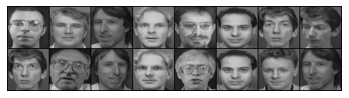

[[1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [8]:
dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [11]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=Config.batch_size)

Epoch number 0
 Current loss 1.8108065128326416

Epoch number 1
 Current loss 1.528283715248108

Epoch number 2
 Current loss 2.2626876831054688

Epoch number 3
 Current loss 1.8855061531066895

Epoch number 4
 Current loss 1.2498836517333984

Epoch number 5
 Current loss 1.3984769582748413

Epoch number 6
 Current loss 1.1598036289215088

Epoch number 7
 Current loss 1.1563560962677002

Epoch number 8
 Current loss 1.0916993618011475

Epoch number 9
 Current loss 1.1280966997146606

Epoch number 10
 Current loss 1.1728794574737549

Epoch number 11
 Current loss 1.1394970417022705

Epoch number 12
 Current loss 1.7999999523162842

Epoch number 13
 Current loss 1.0220234394073486

Epoch number 14
 Current loss 1.1376416683197021

Epoch number 15
 Current loss 1.164123296737671

Epoch number 16
 Current loss 1.1352773904800415

Epoch number 17
 Current loss 1.1573710441589355

Epoch number 18
 Current loss 1.12931489944458

Epoch number 19
 Current loss 1.258582592010498

Epoch number 20

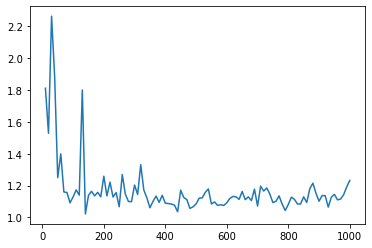

In [13]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,Config.number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data)
show_plot(counter,loss_history)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


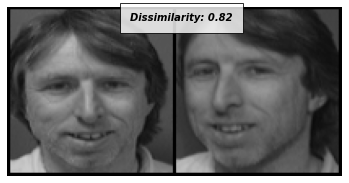

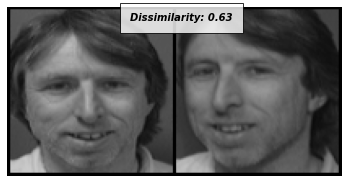

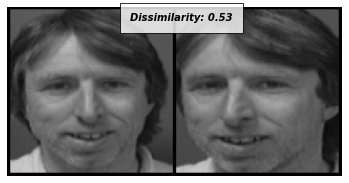

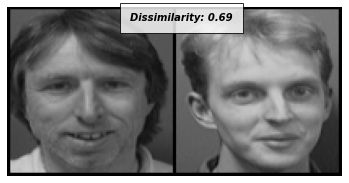

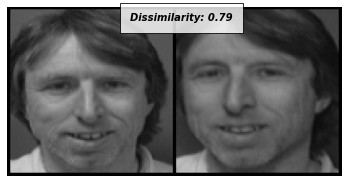

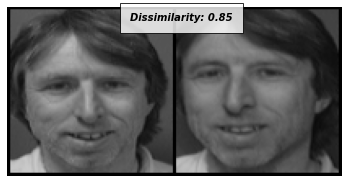

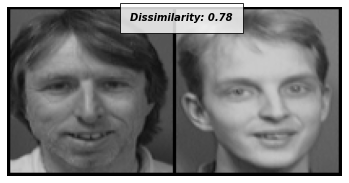

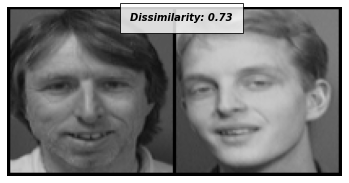

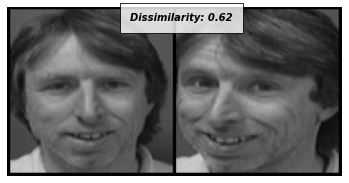

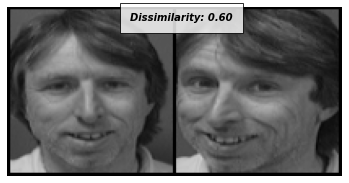

In [56]:
# Testing the network

folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0]))

In [54]:
def oneshot(model,img1,img2):
       # Gives you the feature vector of both inputs
       output1,output2 = model(img1.cuda(),img2.cuda())
       concatenated = torch.cat((img1,img2),0)
       # Compute the distance 
       euclidean_distance = F.pairwise_distance(output1, output2)
       #with certain threshold of distance say its similar or not
       if euclidean_distance > 0.5:
          imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.cpu().data.numpy()[0]))

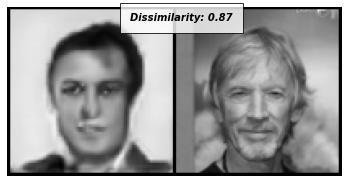

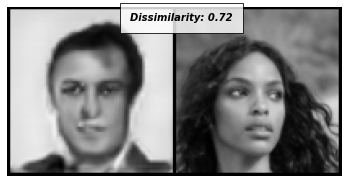

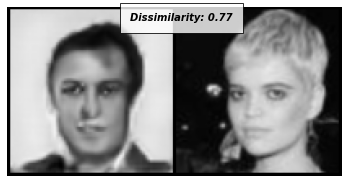

In [55]:
# inferencing
import glob
from PIL import Image, ImageOps

model_path= "/content/drive/MyDrive/CID/models"
trans = transforms.Compose([
                transforms.Resize(100),
                transforms.CenterCrop(100),
                transforms.ToTensor()
                ])
fake_img = Image.open("/content/drive/MyDrive/CID/data/data/tmp.png")
fake_img = trans(ImageOps.grayscale(fake_img)).reshape(1,1,100,100)
images=glob.glob("/content/drive/MyDrive/CID/data/data/images/*jpg")
model = SiameseNetwork()
model.load_state_dict(torch.load(model_path+'/siamese/netSm_epoch_last.pth',map_location=torch.device('cpu')))
model = model.cuda() 
for image in images[:10]:
    img = Image.open(image)
    img = trans(ImageOps.grayscale(img)).reshape(1,1,100,100)
    oneshot(model,Variable(fake_img),Variable(img))